# Quora question pairs: training

## Import packages

In [3]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Initialize global variables

In [10]:
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

## Load the dataset, embedding matrix

In [11]:
q1_data = np.load(open('q1_train.npy', 'rb'))
q2_data = np.load(open('q2_train.npy', 'rb'))
labels = np.load(open('label_train.npy', 'rb'))
word_embedding_matrix = np.load(open('word_embedding_matrix.npy', 'rb'))
with open('nb_words.json', 'r') as f:
    nb_words = json.load(f)['nb_words']

## Partition the dataset into train and test sets

In [12]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

## Define the model

In [22]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

#create embedding using pre-trained GLOVE vectors

embedding_layer = Embedding(word_embedding_matrix.shape[0],
                            EMBEDDING_DIM,
                            weights=[word_embedding_matrix],
                            input_length=25,
                            trainable=False)

#create time distributed embedding for question 1 and question 2
embedded_sequences_1 = embedding_layer(question1)
time_distributed_1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
q1_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_1)


embedded_sequences_2 = embedding_layer(question2)
time_distributed_2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
q2_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_2)

#Concatenate the representations for question 1 and 2
concatenated = concatenate([q1_time_dist,q2_time_dist])

#dense layer 1
merged = Dense(200, activation='relu')(concatenated)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 5
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 6
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#final prediction using sigmoid activation
final_label = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=final_label)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 25, 300)      28947900    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 25, 300)      90300       embedding_5[0][0]                
__________

## Train the model, checkpointing weights with best validation accuracy

In [16]:
#print("Starting training at", datetime.datetime.now())
t0 = time.time()

#callback to store the best weights
callbacks = [ModelCheckpoint('question_pairs_weights_network2.h5', monitor='val_acc', save_best_only=True)]

history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=0.2,
                    verbose=2,
                    batch_size=32,
                    callbacks=callbacks)
t1 = time.time()
#print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Train on 258743 samples, validate on 64686 samples
Epoch 1/25
 - 189s - loss: 0.5593 - acc: 0.7127 - val_loss: 0.5279 - val_acc: 0.7218
Epoch 2/25
 - 192s - loss: 0.5028 - acc: 0.7516 - val_loss: 0.4771 - val_acc: 0.7659
Epoch 3/25
 - 184s - loss: 0.4736 - acc: 0.7691 - val_loss: 0.4720 - val_acc: 0.7695
Epoch 4/25
 - 193s - loss: 0.4506 - acc: 0.7840 - val_loss: 0.4533 - val_acc: 0.7815
Epoch 5/25
 - 172s - loss: 0.4302 - acc: 0.7971 - val_loss: 0.4431 - val_acc: 0.7877
Epoch 6/25
 - 177s - loss: 0.4137 - acc: 0.8076 - val_loss: 0.4332 - val_acc: 0.7929
Epoch 7/25
 - 180s - loss: 0.3968 - acc: 0.8178 - val_loss: 0.4323 - val_acc: 0.7941
Epoch 8/25
 - 197s - loss: 0.3832 - acc: 0.8261 - val_loss: 0.4368 - val_acc: 0.7909
Epoch 9/25
 - 185s - loss: 0.3739 - acc: 0.8315 - val_loss: 0.4374 - val_acc: 0.7921
Epoch 10/25
 - 176s - loss: 0.3638 - acc: 0.8379 - val_loss: 0.4277 - val_acc: 0.7990
Epoch 11/25
 - 191s - loss: 0.3541 - acc: 0.8428 - val_loss: 0.4207 - val_acc: 0.8023
Epoch 12/25


## Plot training and validation accuracy

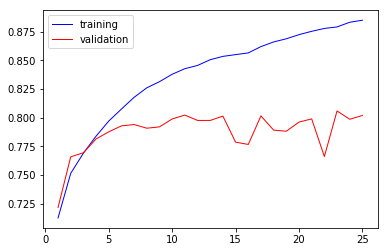

In [17]:
import matplotlib.pyplot as plt
# Data
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21) })
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['acc'],
                    'validation': history.history['val_acc']}) 
# multiple line plot
ax= plt.plot( 'epoch', 'training', data=acc,markersize=12, color='blue', linewidth=1)
ax= plt.plot( 'epoch', 'validation', data=acc,markersize=12, color='red', linewidth=1)

plt.legend()

In [18]:
max_val_acc, idx = max((val, idx) for (idx, val) in enumerate(history.history['val_acc']))
print('Maximum accuracy at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(max_val_acc))

Maximum accuracy at epoch 23 = 0.8059


## Evaluate the model  on the test partition

In [19]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4219, accuracy = 0.8072


# Calculating AUC-ROC

In [20]:
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
pred_label = model.predict([Q1_test, Q2_test], verbose=0)

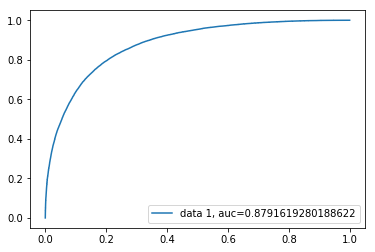

AUC score is =  0.8791619280188622


In [21]:

fpr, tpr, _ = roc_curve(y_test,  pred_label)
auc = roc_auc_score(y_test, pred_label)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print('AUC score is = ', auc)

# Testing individual sentences

### Use this section as a server for the Web Application

In [7]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import pandas as pd
import json
from keras.models import Model
from keras.layers import Input, TimeDistributed, dot, Dense, Lambda, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [8]:
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32

with open('nb_words.json', 'r') as f:
    nb_words = json.load(f)['nb_words']
    
word_embedding_matrix = np.load(open('word_embedding_matrix.npy', 'rb'))

with open('word_index.pickle', 'rb') as handle:
    word_indices = pickle.load(handle)

In [9]:
question1 = Input(shape=(25,))
question2 = Input(shape=(25,))

#create embedding using pre-trained GLOVE vectors

embedding_layer = Embedding(word_embedding_matrix.shape[0],
                            EMBEDDING_DIM,
                            weights=[word_embedding_matrix],
                            input_length=25,
                            trainable=False)

#create time distributed embedding for question 1 and question 2
embedded_sequences_1 = embedding_layer(question1)
time_distributed_1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_1)
q1_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_1)


embedded_sequences_2 = embedding_layer(question2)
time_distributed_2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(embedded_sequences_2)
q2_time_dist = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(time_distributed_2)

#Concatenate the representations for question 1 and 2
concatenated = concatenate([q1_time_dist,q2_time_dist])

#dense layer 1
merged = Dense(200, activation='relu')(concatenated)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#dense layer 2
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 3
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 4
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 5
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)

#dense layer 6
merged = Dense(200, activation='relu')(merged)
#to avoid overfitting
merged = Dropout(DROPOUT)(merged)
merged = BatchNormalization()(merged)


#final prediction using sigmoid activation
final_label = Dense(1, activation='sigmoid')(merged)

model = Model(inputs=[question1,question2], outputs=final_label)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Tensor("dense_9/Sigmoid:0", shape=(?, 1), dtype=float32)


In [10]:
def word2vec(question):
    word_seq = keras.preprocessing.text.text_to_word_sequence(question)
    
    vec_sequence = [word_indices[w] for w in word_seq]
    
    vec_sequence = pad_sequences([vec_sequence], maxlen= 25)
    return vec_sequence
 

#### Input questions

In [18]:
question1 = 'Hi Im here waiting for you.where are you?'
question2 = 'Hi what era is this?'

model.load_weights(MODEL_WEIGHTS_FILE)
predictions = model.predict([word2vec(question1), word2vec(question2)], verbose=0)



In [19]:
predictions

array([[0.0143868]], dtype=float32)